# Analisis Sentimen Ulasan Produk Menggunakan Algoritma Naive Bayes

Notebook ini dibuat untuk memenuhi Tugas Akhir 11 pada mata kuliah Machine Learning.  
Studi kasus yang digunakan adalah analisis sentimen ulasan produk dengan pendekatan klasifikasi teks menggunakan algoritma **Multinomial Naive Bayes**.  

Tahapan yang dilakukan meliputi:
1. Import library dan pemuatan dataset
2. Visualisasi distribusi data
3. Preprocessing data teks
4. Implementasi dan evaluasi model
5. Simulasi prediksi data baru dan analisis probabilitas


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc


## Load Dataset

Dataset yang digunakan adalah dataset ulasan produk (`reviews.csv`) yang berisi
teks ulasan dan skor penilaian produk.


In [2]:
df = pd.read_csv("Reviews.csv")
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Pemeriksaan Struktur Data dan Missing Values

Tahap ini dilakukan untuk mengetahui struktur dataset serta keberadaan nilai
kosong (missing values) yang dapat mempengaruhi proses analisis.


In [3]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

## Penanganan Missing Values

Berdasarkan hasil pengecekan, terdapat beberapa nilai kosong pada kolom
ProfileName dan Summary. Namun, kolom Text sebagai fitur utama analisis
sentimen tidak memiliki nilai kosong.

Oleh karena itu, baris dengan nilai kosong pada kolom lain dihapus untuk
menjaga kebersihan data.


In [4]:
# Menghapus baris dengan nilai kosong
df.dropna(inplace=True)

# Cek ulang missing values
df.isnull().sum()


Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

## Eksplorasi Data Awal

Eksplorasi data dilakukan untuk memahami karakteristik data sebelum dilakukan
preprocessing dan pemodelan.


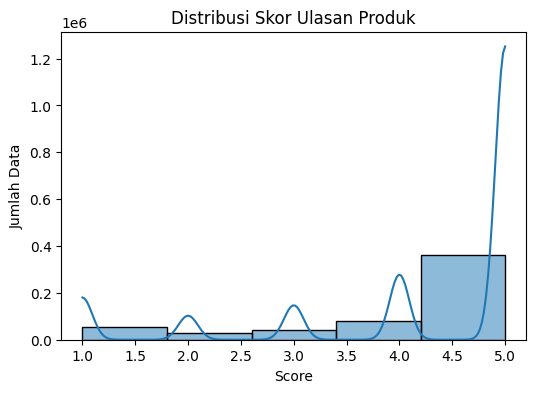

In [5]:
plt.figure(figsize=(6,4))
sns.histplot(df['Score'], bins=5, kde=True)
plt.title("Distribusi Skor Ulasan Produk")
plt.xlabel("Score")
plt.ylabel("Jumlah Data")
plt.show()


## Visualisasi Distribusi Data Menggunakan KDE Plot

Kernel Density Estimate (KDE) Plot digunakan untuk melihat sebaran data secara
kontinu dan membantu memahami karakteristik distribusi skor ulasan.


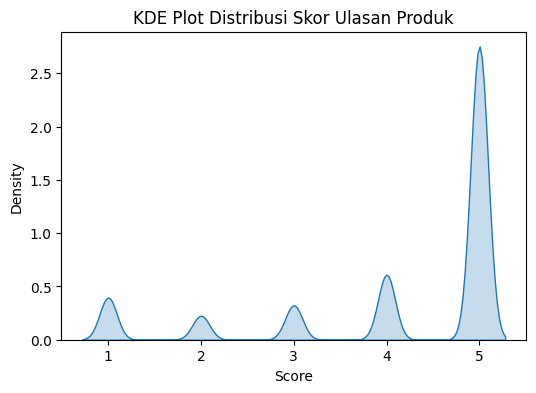

In [6]:
plt.figure(figsize=(6,4))
sns.kdeplot(df['Score'], fill=True)
plt.title("KDE Plot Distribusi Skor Ulasan Produk")
plt.xlabel("Score")
plt.ylabel("Density")
plt.show()


## Preprocessing Data

Tahap preprocessing meliputi:
- Pemilihan kolom yang relevan
- Konversi skor menjadi label sentimen
- Encoding label sentimen
- Transformasi teks menggunakan TF-IDF


In [7]:
df = df[['Score', 'Text']]
df.dropna(inplace=True)

# Buat label sentimen
def label_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score <= 2:
        return 'Negative'
    else:
        return np.nan

df['Sentiment'] = df['Score'].apply(label_sentiment)
df.dropna(inplace=True)

df.head()

,Score,Text,Sentiment
0,5,I have bought several of the Vitality canned d...,Positive
1,1,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,4,This is a confection that has been around a fe...,Positive
3,2,If you are looking for the secret ingredient i...,Negative
4,5,Great taffy at a great price. There was a wid...,Positive


## Distribusi Kelas Sentimen

Visualisasi ini bertujuan untuk melihat keseimbangan jumlah data antara
sentimen positif dan negatif.


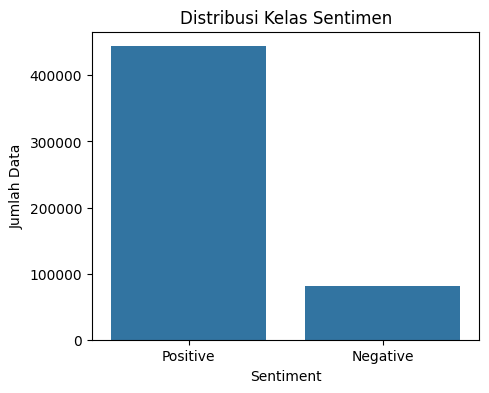

In [8]:
plt.figure(figsize=(5,4))
sns.countplot(x=df['Sentiment'])
plt.title("Distribusi Kelas Sentimen")
plt.xlabel("Sentiment")
plt.ylabel("Jumlah Data")
plt.show()


## Encoding Target

Label sentimen dikonversi ke dalam bentuk numerik agar dapat diproses oleh
algoritma Naive Bayes.


In [9]:
le = LabelEncoder()
df['Sentiment'] = le.fit_transform(df['Sentiment'])

# 0 = Negative, 1 = Positive
df['Sentiment'].value_counts()


Sentiment
1    443756
0     82007
Name: count, dtype: int64

### Ekstraksi Fitur Teks (TF-IDF)

Metode TF-IDF digunakan untuk mengubah teks menjadi representasi numerik
berdasarkan bobot kata.


In [10]:
X = df['Text']
y = df['Sentiment']

tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000
)

X_tfidf = tfidf.fit_transform(X)


## Pembagian Data

Data dibagi menjadi data latih (80%) dan data uji (20%).


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Implementasi Model Multinomial Naive Bayes

Model Multinomial Naive Bayes digunakan karena sesuai untuk data teks.


In [12]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
print("Model Naive Bayes berhasil dilatih.")


Model Naive Bayes berhasil dilatih.


## Evaluasi Model

Evaluasi dilakukan menggunakan Confusion Matrix dan Accuracy Score.


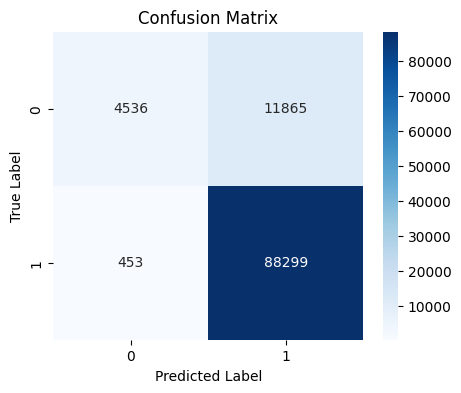

Confusion Matrix:

Accuracy: 0.8829

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.28      0.42     16401
           1       0.88      0.99      0.93     88752

    accuracy                           0.88    105153
   macro avg       0.90      0.64      0.68    105153
weighted avg       0.89      0.88      0.86    105153



In [13]:
y_pred = nb_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Confusion Matrix:")
print("\nAccuracy:", round(acc, 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

## ROC Curve

Receiver Operating Characteristic (ROC) Curve digunakan untuk mengevaluasi
kemampuan model dalam membedakan kelas positif dan negatif pada berbagai
nilai threshold.


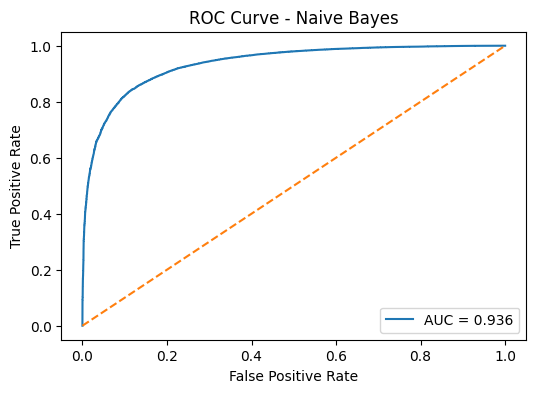

In [14]:
y_test_proba = nb_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend()
plt.show()


## KDE Plot Probabilitas Prediksi


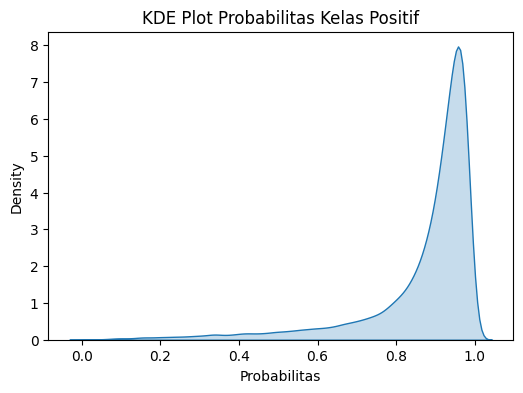

In [15]:
y_proba = nb_model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(6,4))
sns.kdeplot(y_proba, fill=True)
plt.title("KDE Plot Probabilitas Kelas Positif")
plt.xlabel("Probabilitas")
plt.ylabel("Density")
plt.show()


## Analisis Probabilitas Prediksi

Naive Bayes mampu memberikan probabilitas prediksi untuk setiap kelas
menggunakan fungsi predict_proba.


In [16]:
sample_proba = nb_model.predict_proba(X_test[0])
print("Probabilitas [Negative, Positive]:", sample_proba)

Probabilitas [Negative, Positive]: [[0.1348767 0.8651233]]


In [17]:
confidence = np.max(sample_proba) * 100
print("Tingkat Keyakinan Model:", round(confidence, 2), "%")


Tingkat Keyakinan Model: 86.51 %


## Simulasi Prediksi Data Baru

Simulasi dilakukan menggunakan dua ulasan buatan dengan sentimen kontras.


In [18]:
dummy_reviews = [
    "This product is amazing and works perfectly, very satisfied",
    "This product is terrible and useless, very disappointed"
]

dummy_tfidf = tfidf.transform(dummy_reviews)
dummy_pred = nb_model.predict(dummy_tfidf)
dummy_proba = nb_model.predict_proba(dummy_tfidf)

for i, review in enumerate(dummy_reviews):
    print(f"\nUlasan {i+1}: {review}")
    print("Prediksi:", "Positive" if dummy_pred[i] == 1 else "Negative")
    print("Probabilitas:", dummy_proba[i])



Ulasan 1: This product is amazing and works perfectly, very satisfied
Prediksi: Positive
Probabilitas: [0.01708436 0.98291564]

Ulasan 2: This product is terrible and useless, very disappointed
Prediksi: Negative
Probabilitas: [0.88354786 0.11645214]


## Model Saving (Deployment Preparation)

Pada tahap ini, model Multinomial Naive Bayes dan vectorizer disimpan
menggunakan format `.pkl` agar dapat digunakan kembali pada aplikasi web
tanpa perlu melakukan training ulang.


In [19]:
# Simpan model
joblib.dump(nb_model, 'sentiment_nb_model.pkl')

# Simpan vectorizer
joblib.dump(tfidf, 'vectorizer.pkl')


['vectorizer.pkl']

## Kesimpulan

Berdasarkan hasil eksperimen, algoritma Multinomial Naive Bayes mampu
mengklasifikasikan sentimen ulasan produk dengan cukup baik.
Kata-kata bermuatan emosi menjadi faktor utama dalam menentukan hasil prediksi.
